In [87]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [3]:
path = 'data/'

In [4]:
zf19 = zipfile.ZipFile(f'{path}flights_2019.zip') 
zf18 = zipfile.ZipFile(f'{path}flights_2018.zip') 
zf17 = zipfile.ZipFile(f'{path}flights_2017.zip') 
zf16 = zipfile.ZipFile(f'{path}flights_2016.zip') 

In [5]:
flights_19 = pd.read_csv(zf19.open('flights_2019.csv'))
flights_18 = pd.read_csv(zf18.open('flights_2018.csv'))
flights_17 = pd.read_csv(zf17.open('flights_2017.csv'))
flights_16 = pd.read_csv(zf16.open('flights_2016.csv'))

flights = pd.concat([flights_19, flights_18], ignore_index=False)
flights = pd.concat([flights, flights_17], ignore_index=False)
flights = pd.concat([flights, flights_16], ignore_index=False)

In [6]:
flights.shape

(8420999, 20)

In [7]:
flights = flights.iloc[:,1:]

In [8]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2019,1,1,1.0,2359,2.0,50.0,41,9.0,OH,4452,N720PS,CLT,FAY,27.0,118,23,59,2019-01-01 23:00:00
1,2019,1,1,2.0,2359,3.0,543.0,549,-6.0,UA,2304,N75858,LAX,ORD,197.0,1744,23,59,2019-01-01 23:00:00
2,2019,1,1,3.0,2359,4.0,504.0,459,5.0,AA,2317,N928AM,LAX,DFW,148.0,1235,23,59,2019-01-01 23:00:00
3,2019,1,1,3.0,2214,109.0,150.0,1,109.0,AA,2023,N196UW,CLT,PBI,86.0,590,22,14,2019-01-01 22:00:00
4,2019,1,1,3.0,2359,4.0,809.0,822,-13.0,UA,364,N894UA,SFO,PHL,285.0,2521,23,59,2019-01-01 23:00:00


In [9]:
f_cols = ['year', 'month', 'day', 'dep_delay','origin', 'hour', 'time_hour']

In [10]:
flights = flights.loc[:,f_cols]

In [11]:
flights = flights.rename(columns={'hour':'sched_dep_hour'})

In [12]:
flights.head()

,year,month,day,dep_delay,origin,sched_dep_hour,time_hour
0,2019,1,1,2.0,CLT,23,2019-01-01 23:00:00
1,2019,1,1,3.0,LAX,23,2019-01-01 23:00:00
2,2019,1,1,4.0,LAX,23,2019-01-01 23:00:00
3,2019,1,1,109.0,CLT,22,2019-01-01 22:00:00
4,2019,1,1,4.0,SFO,23,2019-01-01 23:00:00


In [13]:
weather = pd.read_csv(f'{path}weather.csv')

In [14]:
weather.head()

,Unnamed: 0,origin,year,month,day,hour,precip,temp,dewp,relh,wind_dir,wind_speed,alti,pressure,visib
0,0,ATL,2016,1,1,0,0.0,44.96,37.94,76.25,300.0,13.0,30.16,1021.4,10.0
1,1,ATL,2016,1,1,1,0.0,42.98,37.04,79.38,320.0,12.0,30.15,1021.1,10.0
2,2,ATL,2016,1,1,2,0.0,42.08,35.96,78.74,320.0,12.0,30.15,1021.1,10.0
3,3,ATL,2016,1,1,3,0.0,42.08,35.06,75.98,320.0,11.0,30.15,1020.9,10.0
4,4,ATL,2016,1,1,4,0.0,41.00,35.06,79.21,330.0,13.0,30.15,1021.1,10.0


In [15]:
weather = weather.iloc[:,1:]

In [16]:
weather.head()

,origin,year,month,day,hour,precip,temp,dewp,relh,wind_dir,wind_speed,alti,pressure,visib
0,ATL,2016,1,1,0,0.0,44.96,37.94,76.25,300.0,13.0,30.16,1021.4,10.0
1,ATL,2016,1,1,1,0.0,42.98,37.04,79.38,320.0,12.0,30.15,1021.1,10.0
2,ATL,2016,1,1,2,0.0,42.08,35.96,78.74,320.0,12.0,30.15,1021.1,10.0
3,ATL,2016,1,1,3,0.0,42.08,35.06,75.98,320.0,11.0,30.15,1020.9,10.0
4,ATL,2016,1,1,4,0.0,41.00,35.06,79.21,330.0,13.0,30.15,1021.1,10.0


In [17]:
airlines = pd.read_csv(f'{path}airlines.csv')

In [18]:
airlines.shape

(1712, 2)

In [19]:
airports = pd.read_csv(f'{path}airports.csv')

In [20]:
key_airports = airports[airports.faa.isin(['ATL', 'LAX', 'ORD', 'DFW', 'DEN', 'JFK', 'SFO', 'LAS', 'SEA', 'CLT'])]
key_airports = key_airports.set_index('faa').to_dict('index')

joblib.dump(key_airports,'test pilot/test_app/artifacts/key_airports.pkl')

In [21]:
df = pd.merge(flights, weather, how='inner', left_on=['origin','year','month','day','sched_dep_hour'], right_on = ['origin','year','month','day','hour'])

df['delayed'] = np.where(df['dep_delay'] >= 15, 1, 0)

df.drop('dep_delay', axis=1, inplace=True)

df['time_hour'] = pd.to_datetime(df['time_hour'])
df['day_of_week'] = df['time_hour'].dt.day_name()
df['month'] = df['time_hour'].dt.month_name()

df = df.groupby(['year', 'month', 'day_of_week', 'origin']).agg(
    {'precip':['mean'], 'temp':['mean'], 'dewp':['mean'], 'relh':['mean'], 'wind_dir':['mean'], 'wind_speed':['mean'], 'pressure':['mean'], \
    'visib':['mean'], 'delayed':['sum','count']}
)

df.reset_index(inplace=True)

df['delay_rate'] = df.iloc[:,-2]/df.iloc[:,-1]

df.columns = df.columns.droplevel(1)
df = df.rename_axis(None, axis=1)

df.drop(['delayed', 'year'], axis=1, inplace=True)

df = df[['day_of_week'] + [col for col in df.columns if col != 'day_of_week']]

df = pd.get_dummies(df)

df = df[[c for c in df if c not in ['delay_rate']] + ['delay_rate']]

df.dropna(axis=0, inplace=True)

In [22]:
df.head()

,precip,temp,dewp,relh,wind_dir,wind_speed,pressure,visib,day_of_week_Friday,day_of_week_Monday,...,origin_CLT,origin_DEN,origin_DFW,origin_JFK,origin_LAS,origin_LAX,origin_ORD,origin_SEA,origin_SFO,delay_rate
0,0.003236,66.204664,49.597155,59.069857,185.057184,8.075590,1014.966172,9.643495,1,0,...,0,0,0,0,0,0,0,0,0,0.188349
1,0.005346,65.330210,47.199530,56.741844,155.499046,6.666243,1014.672219,9.511125,1,0,...,1,0,0,0,0,0,0,0,0,0.131596
2,0.006643,47.437707,27.869576,52.530377,165.196327,7.543065,1014.171374,8.056444,1,0,...,0,1,0,0,0,0,0,0,0,0.179861
3,0.000737,69.632365,47.634047,49.587692,144.121646,8.295886,1014.087549,9.235778,1,0,...,0,0,1,0,0,0,0,0,0,0.200000
4,0.000429,53.739342,39.822216,62.048449,174.703360,10.609721,1013.767262,9.068799,1,0,...,0,0,0,1,0,0,0,0,0,0.220872


In [23]:
df.shape

(3360, 38)

In [24]:
seed = 6242

In [25]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=seed)

### Random Forest

In [26]:
rf_base = RandomForestRegressor(random_state=seed)
rf_base.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])
rf_base_preds = rf_base.predict(df_test.iloc[:,:-1])

print('Mean Absolute Error (Baseline):', metrics.mean_absolute_error(df_test.iloc[:,-1], rf_base_preds))  
print('Mean Squared Error (Baseline):', metrics.mean_squared_error(df_test.iloc[:,-1], rf_base_preds))  
print('Root Mean Squared Error (Baseline):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], rf_base_preds)))

Mean Absolute Error (Baseline): 0.03390136000688167
Mean Squared Error (Baseline): 0.0019497426955886312
Root Mean Squared Error (Baseline): 0.044155890836768664


#### Random forest hyperparameter tuning

In [27]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
max_depth

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

In [28]:
rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(100, 1000, 20)],
               'criterion':['squared_error', 'absolute_error', 'poisson'],
               'max_depth': max_depth,
               'min_samples_split': [2,4,6,8,10],
               'min_samples_leaf': [1, 2, 4, 8],
               'max_features': ['auto', 'sqrt', 'log2', None],
               'min_samples_split': [2, 5, 10],
               'bootstrap': [True, False]}

In [29]:
rf_est = RandomForestRegressor(random_state=seed)

rf_random = RandomizedSearchCV(estimator = rf_est, 
                         param_distributions = rf_param_grid, 
                         cv = 10, 
                         verbose=2, 
                         random_state=seed, 
                         n_jobs = -1)

In [30]:
rf_random.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=6242),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 147, 194, 242,
                                                         289, 336, 384, 431,
             

In [31]:
rf_random.best_params_

{'n_estimators': 336,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 60,
 'criterion': 'absolute_error',
 'bootstrap': True}

In [32]:
rf_tuned_preds = rf_random.predict(df_test.iloc[:,:-1])

In [33]:
print('Mean Absolute Error (Tuned):', metrics.mean_absolute_error(df_test.iloc[:,-1], rf_tuned_preds))  
print('Mean Squared Error (Tuned):', metrics.mean_squared_error(df_test.iloc[:,-1], rf_tuned_preds))  
print('Root Mean Squared Error (Tuned):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], rf_tuned_preds)))

Mean Absolute Error (Tuned): 0.03440837743947034
Mean Squared Error (Tuned): 0.002018949010310467
Root Mean Squared Error (Tuned): 0.04493271648042734


### Histogram-Based Gradient Boosting Regression Tree

In [34]:
gb_base = HistGradientBoostingRegressor(random_state=seed)
gb_base.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])
gb_base_preds = gb_base.predict(df_test.iloc[:,:-1])

print('Mean Absolute Error (Baseline):', metrics.mean_absolute_error(df_test.iloc[:,-1], gb_base_preds))  
print('Mean Squared Error (Baseline):', metrics.mean_squared_error(df_test.iloc[:,-1], gb_base_preds))  
print('Root Mean Squared Error (Baseline):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], gb_base_preds)))

Mean Absolute Error (Baseline): 0.03235441939431025
Mean Squared Error (Baseline): 0.0017961309593508168
Root Mean Squared Error (Baseline): 0.042380785261139475


In [35]:
gb_base.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 6242,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### Hist GB Parameter Tuning

In [36]:
max_depth = [int(x) for x in np.linspace(700, 1200, num = 10)]
max_depth.append(None)
max_depth

[700, 755, 811, 866, 922, 977, 1033, 1088, 1144, 1200, None]

In [37]:
gb_param_grid = {'loss':['squared_error', 'absolute_error'],
                 'learning_rate': [x for x in np.linspace(0.01, 0.4, 5)],
                 'max_iter':[int(x) for x in np.linspace(500, 1000, 5)],
                 'max_leaf_nodes':[int(x) for x in np.linspace(2, 100, 5)],
                 'min_samples_leaf': [5, 6, 7],
                 'max_depth': max_depth}

In [38]:
gb_est = HistGradientBoostingRegressor(random_state=seed)

gb_random = RandomizedSearchCV(estimator = gb_est, 
                         param_distributions = gb_param_grid, 
                         cv = 10, 
                         verbose=2, 
                         random_state=seed, 
                         n_jobs = -1)

In [39]:
gb_random.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=HistGradientBoostingRegressor(random_state=6242),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1075,
                                                          0.20500000000000002,
                                                          0.3025, 0.4],
                                        'loss': ['squared_error',
                                                 'absolute_error'],
                                        'max_depth': [700, 755, 811, 866, 922,
                                                      977, 1033, 1088, 1144,
                                                      1200, None],
                                        'max_iter': [500, 625, 750, 875, 1000],
                                        'max_leaf_nodes': [2, 26, 51, 75, 100],
                                        'min_samples_leaf': [5, 6, 7]},
                   random_state=6242, verbose=2)

In [40]:
gb_random.best_params_

{'min_samples_leaf': 5,
 'max_leaf_nodes': 26,
 'max_iter': 750,
 'max_depth': 866,
 'loss': 'squared_error',
 'learning_rate': 0.01}

In [41]:
gb_tuned_preds = gb_random.predict(df_test.iloc[:,:-1])

In [42]:
print('Mean Absolute Error (Tuned):', metrics.mean_absolute_error(df_test.iloc[:,-1], gb_tuned_preds))  
print('Mean Squared Error (Tuned):', metrics.mean_squared_error(df_test.iloc[:,-1], gb_tuned_preds))  
print('Root Mean Squared Error (Tuned):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], gb_tuned_preds)))

Mean Absolute Error (Tuned): 0.03236206549817091
Mean Squared Error (Tuned): 0.0017750462614690723
Root Mean Squared Error (Tuned): 0.04213129788493433


### Lasso Regression

In [43]:
ls_base = Lasso(random_state=seed)
ls_base.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])
ls_base_preds = ls_base.predict(df_test.iloc[:,:-1])

print('Mean Absolute Error (Baseline):', metrics.mean_absolute_error(df_test.iloc[:,-1], ls_base_preds))  
print('Mean Squared Error (Baseline):', metrics.mean_squared_error(df_test.iloc[:,-1], ls_base_preds))  
print('Root Mean Squared Error (Baseline):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], ls_base_preds)))

Mean Absolute Error (Baseline): 0.051772984511678846
Mean Squared Error (Baseline): 0.004041084803200077
Root Mean Squared Error (Baseline): 0.06356952731616052


In [44]:
ls_pipe = Pipeline([("Scale", MinMaxScaler()), ("ls", Lasso())])

ls_param_grid = {'ls__alpha':np.arange(0.0001,0.99,0.005),
                 'ls__tol':[1e-10],
                 'ls__max_iter':[10000]
                }

ls_random = GridSearchCV(estimator = ls_pipe, 
                         param_grid = ls_param_grid, 
                         cv = 10, 
                         verbose=2, 
                         #random_state=seed, 
                         n_jobs = -1)

In [45]:
ls_random.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

Fitting 10 folds for each of 198 candidates, totalling 1980 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Scale', MinMaxScaler()),
                                       ('ls', Lasso())]),
             n_jobs=-1,
             param_grid={'ls__alpha': array([1.000e-04, 5.100e-03, 1.010e-02, 1.510e-02, 2.010e-02, 2.510e-02,
       3.010e-02, 3.510e-02, 4.010e-02, 4.510e-02, 5.010e-02, 5.510e-02,
       6.010e-02, 6.510e-02, 7.010e-02, 7.510e-02, 8.010e-02, 8.510e-02,
       9.010e-02, 9.510e-02, 1.001e-01, 1.051e-01, 1....
       8.401e-01, 8.451e-01, 8.501e-01, 8.551e-01, 8.601e-01, 8.651e-01,
       8.701e-01, 8.751e-01, 8.801e-01, 8.851e-01, 8.901e-01, 8.951e-01,
       9.001e-01, 9.051e-01, 9.101e-01, 9.151e-01, 9.201e-01, 9.251e-01,
       9.301e-01, 9.351e-01, 9.401e-01, 9.451e-01, 9.501e-01, 9.551e-01,
       9.601e-01, 9.651e-01, 9.701e-01, 9.751e-01, 9.801e-01, 9.851e-01]),
                         'ls__max_iter': [10000], 'ls__tol': [1e-10]},
             verbose=2)

In [46]:
ls_random.best_params_

{'ls__alpha': 0.0001, 'ls__max_iter': 10000, 'ls__tol': 1e-10}

In [47]:
ls_tuned_preds = ls_random.predict(df_test.iloc[:,:-1])

In [48]:
print('Mean Absolute Error (Tuned):', metrics.mean_absolute_error(df_test.iloc[:,-1], ls_tuned_preds))  
print('Mean Squared Error (Tuned):', metrics.mean_squared_error(df_test.iloc[:,-1], ls_tuned_preds))  
print('Root Mean Squared Error (Tuned):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], ls_tuned_preds)))

Mean Absolute Error (Tuned): 0.03584562768574724
Mean Squared Error (Tuned): 0.0021100086775051
Root Mean Squared Error (Tuned): 0.045934830766043974


### Stacking Predictors


In [49]:
rf_best = rf_random.best_params_
rf_model = RandomForestRegressor(**rf_best, random_state=seed)

gb_best = gb_random.best_params_
gb_model = HistGradientBoostingRegressor(**gb_best, random_state=seed)

ls_best = ls_random.best_params_
#ls_model = Lasso(alpha=0.1, random_state=seed)

ls_model = Pipeline([("Scale", StandardScaler()), ("ls", Lasso(alpha=0.0001))])

estimators = [('Random Forest', rf_model),
              ('Gradient Boosting', gb_model),
              ('Lasso', ls_model)]

stacking = StackingRegressor(estimators = estimators, final_estimator=RidgeCV())

In [50]:
stacking.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=60,
                                                     min_samples_leaf=4,
                                                     n_estimators=336,
                                                     random_state=6242)),
                              ('Gradient Boosting',
                               HistGradientBoostingRegressor(learning_rate=0.01,
                                                             max_depth=866,
                                                             max_iter=750,
                                                             max_leaf_nodes=26,
                                                             min_samples_leaf=5,
                                                             random_state=6242)),
                              ('Lasso',
                   

In [51]:
s_preds = stacking.predict(df_test.iloc[:,:-1])

In [52]:
print('Mean Absolute Error (Tuned):', metrics.mean_absolute_error(df_test.iloc[:,-1], s_preds))  
print('Mean Squared Error (Tuned):', metrics.mean_squared_error(df_test.iloc[:,-1], s_preds))  
print('Root Mean Squared Error (Tuned):', np.sqrt(metrics.mean_squared_error(df_test.iloc[:,-1], s_preds)))

Mean Absolute Error (Tuned): 0.03245729155645038
Mean Squared Error (Tuned): 0.001774398286699788
Root Mean Squared Error (Tuned): 0.042123607237507424


### Results: 

switch out s_preds here with rf_tuned_preds/gb_tuned_preds/ls_tuned_preds/s_preds to visualize different models

ideally the results would be as close to the dotted line as possible, appears all methods are overpredicting low values and underpredicting high values to some extent

In [54]:
df_test_p = df_test.copy()

In [55]:
df_test_p.reset_index(inplace=True, drop=True)

df_test_p.head()

,precip,temp,dewp,relh,wind_dir,wind_speed,pressure,visib,day_of_week_Friday,day_of_week_Monday,...,origin_CLT,origin_DEN,origin_DFW,origin_JFK,origin_LAS,origin_LAX,origin_ORD,origin_SEA,origin_SFO,delay_rate
0,0.001589,53.973333,46.702917,76.899422,103.526042,7.221875,1020.066250,9.659896,0,0,...,0,0,0,0,0,0,0,0,1,0.210417
1,0.000000,92.288903,29.119916,11.447207,129.485232,6.364557,1006.211857,10.000000,1,0,...,0,0,0,0,1,0,0,0,0,0.227004
2,0.001502,33.298743,25.747829,75.030245,198.058222,7.818210,1014.075751,8.663363,0,1,...,0,0,0,0,0,0,1,0,0,0.244967
3,0.000352,45.207047,32.368408,65.535541,214.908870,7.452612,1023.598603,7.608900,0,0,...,0,0,1,0,0,0,0,0,0,0.224180
4,0.020845,54.987475,43.464919,66.735652,193.360489,9.146640,1018.074287,9.311864,0,0,...,0,0,0,0,0,1,0,0,0,0.192974


In [56]:
preds = np.array([rf_tuned_preds, gb_tuned_preds, ls_tuned_preds, s_preds]).T

df_preds = pd.DataFrame(preds, columns=['Random Forest', 'Histgram Based Gradient Boosting', 'Lasso', 'Stacked Model'])

In [57]:
df_preds['Actuals'] = df_test_p.iloc[:,-1]
df_preds.head()

,Random Forest,Histgram Based Gradient Boosting,Lasso,Stacked Model,Actuals
0,0.192365,0.205821,0.205825,0.205792,0.210417
1,0.221024,0.236003,0.257757,0.246501,0.227004
2,0.206442,0.201223,0.203465,0.203723,0.244967
3,0.177766,0.166809,0.187560,0.173726,0.224180
4,0.216467,0.255298,0.207721,0.238738,0.192974


In [58]:
for column in df_preds.columns:
    df_preds[column] = df_preds.loc[:, column] - df_preds.loc[:, 'Actuals']

df_preds.sample(10)

,Random Forest,Histgram Based Gradient Boosting,Lasso,Stacked Model,Actuals
984,0.040120,0.025612,0.017666,0.018123,0.0
215,0.037898,0.019013,0.071765,0.034718,0.0
535,-0.001340,-0.017364,0.007060,-0.007207,0.0
200,-0.000464,0.013877,0.006027,0.024924,0.0
872,-0.008298,-0.015787,-0.022706,-0.023617,0.0
435,-0.042065,-0.033146,-0.039227,-0.040081,0.0
708,-0.015568,-0.001975,0.041784,0.017659,0.0
802,0.000584,-0.011733,-0.000107,-0.009095,0.0
240,-0.052476,-0.040763,-0.050048,-0.042758,0.0
269,0.040671,0.037837,0.052911,0.046080,0.0


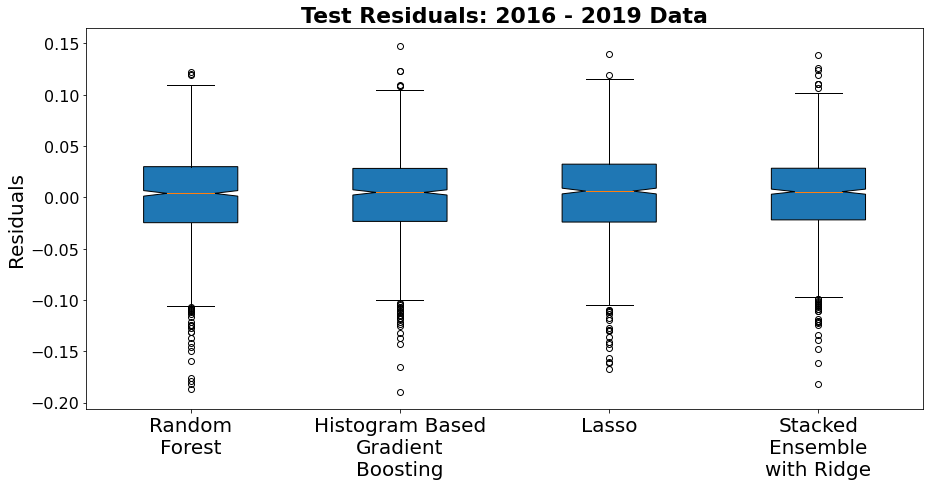

In [62]:
rf_res = df_preds.iloc[:,0]
gb_res = df_preds.iloc[:,1]
ls_res = df_preds.iloc[:,2]
st_res = df_preds.iloc[:,3]

columns = [rf_res, gb_res, ls_res, st_res]

colors = ["#003057","#003057","#003057","#003057"]

plt.figure(figsize=(15,7))

#fig, ax = plt.subplots()
plt.boxplot(columns, notch=True, patch_artist=True)
plt.xticks([1,2,3,4], ['Random\nForest', 'Histogram Based\nGradient\nBoosting', 'Lasso', 'Stacked\nEnsemble\nwith Ridge'], rotation=0, fontsize=20)
plt.yticks(fontsize=16)
plt.ylabel('Residuals', fontsize=20)
plt.title('Test Residuals: 2016 - 2019 Data', fontsize=22, fontweight='bold')

plt.show()


### Feature Importance: Tuned Hist GB 

In [144]:
importances = permutation_importance(gb_random.best_estimator_, df_test.iloc[:,:-1], df_test.iloc[:,-1], n_repeats =100, random_state=seed, n_jobs=-1)

sorted_importances_idx = importances.importances_mean.argsort()
importances = pd.DataFrame(
    importances.importances[sorted_importances_idx].T,
    columns=df_test.columns[sorted_importances_idx],
)

In [145]:
importances = importances[['relh','wind_dir','wind_speed','visib','dewp','temp','pressure','precip']]
importances = importances.rename(columns={'wind_dir': 'Wind Direction', 'dewp':'Dew Point', 'relh':'Relative Humidity', 'wind_speed':'Wind Speed',  'pressure':'Pressure', 'visib':'Visibility', 'precip':'Precipitation', 'temp':'Temperature'})

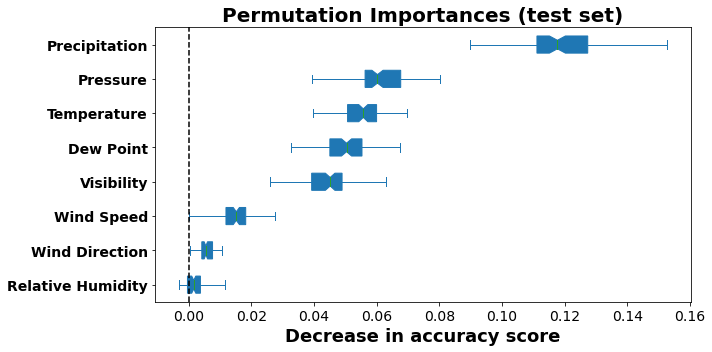

In [146]:
fig, ax = plt.subplots(figsize=(10, 5))
importances.plot.box(ax=ax, vert=False, whis=10, notch=True, patch_artist=True)
ax.set_title("Permutation Importances (test set)", fontsize=20, fontweight="bold")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
ax.figure.tight_layout()

### Whichever model we end up using dump to pickle file below

In [ ]:
joblib.dump(rf_random,'artifacts/rf_model.pkl')

In [ ]:
joblib.dump(ls_random,'artifacts/ls_model.pkl')

In [ ]:
joblib.dump(gb_random,'artifacts/gb_model.pkl')

In [ ]:
joblib.dump(stacking,'artifacts/stacking_model.pkl')

#### Example prediction from stored pickle files

In [ ]:
test_model = joblib.load('artifacts/gb_model.pkl')

In [ ]:
test_obs = np.array(df_test.iloc[1,:-1]).reshape(1, -1)

In [ ]:
test_model.predict(test_obs)

c:\Users\sasch\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([0.23600334])